In [1]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 22.7 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import os
import pandas as pd
import random
from datetime import datetime, timedelta
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

## Session 1 : Prepare Training data

In [6]:
# 因為本次的競賽我們是在 colab 上運行，因此如果要在其他的環境上運行除了要裝載相對應的套件跟確保是否可以使用 GPU 訓練外還需要設定 training data 跟 testing data 以及 output 的路徑
url_training_data = r"/content/drive/MyDrive/Colab Notebooks/Data science competition/T-brain 2024 Sun light Power predition/Training data"
url_testing_data = '/content/drive/MyDrive/Colab Notebooks/Data science competition/T-brain 2024 Sun light Power predition/Testing data'
url_output = '/content/drive/MyDrive/Colab Notebooks/Data science competition/T-brain 2024 Sun light Power predition/Testing data/'

In [3]:
# 設定工作目錄
url_training_data = r"/content/drive/MyDrive/Colab Notebooks/Data science competition/T-brain 2024 Sun light Power predition/Training data"
os.chdir(url_training_data)
print("Current working directory:", os.getcwd())

# 初始化一個空的 DataFrame 來存放所有站點的資料
combined_data = pd.DataFrame()

# 讀取 17 個站點的資料並合併
for site_id in range(1, 18):  # 從 1 到 17
    site = "L"+str(site_id)  # 確保編號為兩位數格式，例如 '01', '02'
    file_path = f"{site}_Train.csv"  # 文件名
    print(f"Loading data for site {site} from {file_path}...")

    # 讀取該站點的 CSV 文件
    df_site = pd.read_csv(file_path)

    # 日期時間處理
    df_site['DateTime'] = pd.to_datetime(df_site['DateTime'])
    df_site['Month'] = df_site['DateTime'].dt.to_period('M')
    df_site['Date'] = df_site['DateTime'].dt.date
    df_site['DateTime'] = df_site['DateTime'].dt.floor('min')  # 只保留到分鐘

    # 添加一個站點標籤列，用於區分不同站點的資料
    df_site['Site'] = site

    # 將該站點的資料合併到總資料框
    combined_data = pd.concat([combined_data, df_site], ignore_index=True)

# 查看合併後的資料框
print("Combined data shape:", combined_data.shape)
print(combined_data.head())

# 保存合併後的資料（可選）
combined_data.to_csv("Combined_Training_Data.csv", index=False)
print("Combined data saved to 'Combined_Training_Data.csv'")

Current working directory: /content/drive/MyDrive/Colab Notebooks/Data science competition/T-brain 2024 Sun light Power predition/Training data
Loading data for site L1 from L1_Train.csv...
Loading data for site L2 from L2_Train.csv...
Loading data for site L3 from L3_Train.csv...
Loading data for site L4 from L4_Train.csv...
Loading data for site L5 from L5_Train.csv...
Loading data for site L6 from L6_Train.csv...
Loading data for site L7 from L7_Train.csv...
Loading data for site L8 from L8_Train.csv...
Loading data for site L9 from L9_Train.csv...
Loading data for site L10 from L10_Train.csv...
Loading data for site L11 from L11_Train.csv...
Loading data for site L12 from L12_Train.csv...
Loading data for site L13 from L13_Train.csv...
Loading data for site L14 from L14_Train.csv...
Loading data for site L15 from L15_Train.csv...
Loading data for site L16 from L16_Train.csv...
Loading data for site L17 from L17_Train.csv...
Combined data shape: (1375028, 11)
   LocationCode        

In [5]:
combined_data.head()

,LocationCode,DateTime,WindSpeed(m/s),Pressure(hpa),Temperature(°C),Humidity(%),Sunlight(Lux),Power(mW),Month,Date,Site
0,1,2024-01-01 06:31:00,0.0,1016.50,17.5,86.8,25.00,0.0,2024-01,2024-01-01,L1
1,1,2024-01-01 06:32:00,0.0,1016.53,17.5,86.7,28.33,0.0,2024-01,2024-01-01,L1
2,1,2024-01-01 06:33:00,0.0,1016.57,17.5,86.7,32.50,0.0,2024-01,2024-01-01,L1
3,1,2024-01-01 06:34:00,0.0,1016.58,17.5,86.7,39.17,0.0,2024-01,2024-01-01,L1
4,1,2024-01-01 06:35:00,0.0,1016.59,17.5,86.7,45.83,0.0,2024-01,2024-01-01,L1


In [6]:
# filter timestamp 7:00-16:59
combined_data['Hour-Minute'] = combined_data['DateTime'].dt.time
combined_data = combined_data[
    (combined_data['Hour-Minute'] >= pd.to_datetime('07:00').time()) &
    (combined_data['Hour-Minute'] < pd.to_datetime('17:00').time())
]
combined_data = combined_data.reset_index(drop=True)
combined_data = combined_data.drop(columns=['LocationCode'])
combined_data

,DateTime,WindSpeed(m/s),Pressure(hpa),Temperature(°C),Humidity(%),Sunlight(Lux),Power(mW),Month,Date,Site,Hour-Minute
0,2024-01-01 07:00:00,0.0,1016.69,17.5,86.9,415.83,0.07,2024-01,2024-01-01,L1,07:00:00
1,2024-01-01 07:01:00,0.0,1016.71,17.5,87.0,429.17,0.08,2024-01,2024-01-01,L1,07:01:00
2,2024-01-01 07:02:00,0.0,1016.69,17.5,87.0,434.17,0.08,2024-01,2024-01-01,L1,07:02:00
3,2024-01-01 07:03:00,0.0,1016.73,17.5,87.0,431.67,0.08,2024-01,2024-01-01,L1,07:03:00
4,2024-01-01 07:04:00,0.0,1016.76,17.5,87.0,445.00,0.07,2024-01,2024-01-01,L1,07:04:00
...,...,...,...,...,...,...,...,...,...,...,...
1041443,2024-07-12 15:26:00,0.0,1004.05,36.5,65.4,12315.00,35.91,2024-07,2024-07-12,L17,15:26:00
1041444,2024-07-12 15:27:00,0.0,1004.08,36.5,64.7,12692.50,38.23,2024-07,2024-07-12,L17,15:27:00
1041445,2024-07-12 15:28:00,0.0,1004.10,36.5,64.5,12960.00,39.95,2024-07,2024-07-12,L17,15:28:00
1041446,2024-07-12 15:29:00,0.0,1004.11,36.4,64.9,12751.67,38.51,2024-07,2024-07-12,L17,15:29:00


In [7]:
# Combine duplicate instance
combined_data = combined_data.groupby(['DateTime','Site','Month','Date','Hour-Minute']).mean().reset_index()
combined_data

,DateTime,Site,Month,Date,Hour-Minute,WindSpeed(m/s),Pressure(hpa),Temperature(°C),Humidity(%),Sunlight(Lux),Power(mW)
0,2024-01-01 07:00:00,L1,2024-01,2024-01-01,07:00:00,0.0,1016.69,17.50,86.9,415.83,0.07
1,2024-01-01 07:00:00,L17,2024-01,2024-01-01,07:00:00,0.0,1023.19,18.00,64.4,617.50,0.13
2,2024-01-01 07:01:00,L1,2024-01,2024-01-01,07:01:00,0.0,1016.71,17.50,87.0,429.17,0.08
3,2024-01-01 07:01:00,L17,2024-01,2024-01-01,07:01:00,0.0,1023.18,18.00,64.7,758.33,0.14
4,2024-01-01 07:02:00,L1,2024-01,2024-01-01,07:02:00,0.0,1016.69,17.50,87.0,434.17,0.08
...,...,...,...,...,...,...,...,...,...,...,...
1040134,2024-10-30 14:26:00,L8,2024-10,2024-10-30,14:26:00,0.0,1001.96,28.65,100.0,3249.17,2.53
1040135,2024-10-30 14:27:00,L8,2024-10,2024-10-30,14:27:00,0.0,1001.92,28.66,100.0,3415.00,2.64
1040136,2024-10-30 14:28:00,L8,2024-10,2024-10-30,14:28:00,0.0,1001.88,28.67,100.0,3433.33,2.61
1040137,2024-10-30 14:29:00,L8,2024-10,2024-10-30,14:29:00,0.0,1002.00,28.70,100.0,3340.83,2.58


In [8]:
# Check the missing date and
# 定義完整日期範圍
start_date = min(combined_data['Date']).strftime('%Y-%m-%d')
end_date = max(combined_data['Date']).strftime('%Y-%m-%d')
full_date_range = pd.date_range(start=start_date, end=end_date)

# 提取現有資料的日期並去重
existing_dates = pd.to_datetime(combined_data['Date']).drop_duplicates()

# 找出完全沒有值的日期
missing_dates = full_date_range.difference(existing_dates)


# 顯示結果
print("Missing Dates:")
print("Number :",len(missing_dates))
print(missing_dates)

missing_dates = [d.date() for d in missing_dates]

Missing Dates:
Number : 25
DatetimeIndex(['2024-07-25', '2024-07-26', '2024-07-27', '2024-07-28',
               '2024-07-29', '2024-07-30', '2024-07-31', '2024-08-01',
               '2024-08-02', '2024-08-03', '2024-08-04', '2024-08-05',
               '2024-08-06', '2024-08-07', '2024-08-08', '2024-08-23',
               '2024-08-24', '2024-08-25', '2024-09-10', '2024-09-14',
               '2024-09-15', '2024-10-04', '2024-10-05', '2024-10-06',
               '2024-10-07'],
              dtype='datetime64[ns]', freq=None)


In [9]:
import pandas as pd
import numpy as np

# 函數：處理單個站點的資料
def process_site_data(site, combined_data, del_threshold):
    # 篩選單一站點的資料
    combined_data_summary = combined_data[combined_data['Site'] == site].reset_index(drop=True).sort_values(by='DateTime')

    # 生成完整的時間範圍
    start_time = pd.to_datetime(min(combined_data_summary['Date']).strftime('%Y-%m-%d') + ' 07:00:00')
    end_time = pd.to_datetime(max(combined_data_summary['Date']).strftime('%Y-%m-%d') + ' 17:00:00')
    full_time_range = pd.date_range(start=start_time, end=end_time, freq='T')
    full_time_df = pd.DataFrame({'DateTime': full_time_range})
    full_time_df = full_time_df[
        (full_time_df['DateTime'].dt.time >= pd.to_datetime('07:00').time()) &
        (full_time_df['DateTime'].dt.time < pd.to_datetime('17:00').time())
    ].reset_index(drop=True)

    # 合併資料
    combined_data_summary = pd.merge(full_time_df, combined_data_summary, on='DateTime', how='left')
    combined_data_summary['Month'] = combined_data_summary['DateTime'].dt.to_period('M')
    combined_data_summary['Date'] = combined_data_summary['DateTime'].dt.date
    combined_data_summary['Hour-Minute'] = combined_data_summary['DateTime'].dt.time

    # 生成每 10 分鐘分組
    numeric_columns = ['WindSpeed(m/s)', 'Pressure(hpa)', 'Temperature(°C)',
                       'Humidity(%)', 'Sunlight(Lux)', 'Power(mW)']
    combined_data_summary['10min_Group'] = (combined_data_summary['DateTime'].dt.floor('10min'))

    # 按 10 分鐘分組計算平均值
    ten_min_avg_summary = combined_data_summary.groupby('10min_Group')[numeric_columns].mean().reset_index()
    ten_min_avg_summary['Date'] = ten_min_avg_summary['10min_Group'].dt.date
    ten_min_avg_summary['Month'] = ten_min_avg_summary['10min_Group'].dt.to_period('M')

    # 移除缺失值過多的日期 (當天的缺失資料比例大於 0.5 的資料)
    missing_power_counts_10mins = ten_min_avg_summary.groupby('Date')['Power(mW)'].apply(lambda x: x.isnull().sum()).reset_index()
    missing_power_counts_10mins.columns = ['Date', 'MissingCount']
    missing_power_counts_10mins['missing_percentage'] = missing_power_counts_10mins['MissingCount'] / 60
    Filter_dates_list = missing_power_counts_10mins[missing_power_counts_10mins['missing_percentage'] > del_threshold].Date
    ten_min_avg_summary = ten_min_avg_summary[~ten_min_avg_summary['Date'].isin(Filter_dates_list)].reset_index(drop=True)

    # 補值
    ten_min_avg_summary['10min_Group'] = pd.to_datetime(ten_min_avg_summary['10min_Group'])
    ten_min_avg_summary = ten_min_avg_summary.set_index('10min_Group')
    ten_min_avg_summary[numeric_columns] = ten_min_avg_summary[numeric_columns].interpolate(method='time')
    ten_min_avg_summary = ten_min_avg_summary.reset_index()
    ten_min_avg_summary['Time'] = ten_min_avg_summary['10min_Group'].dt.time

    # 添加站點標籤
    ten_min_avg_summary['Site'] = site

    return ten_min_avg_summary

# 初始化空的 DataFrame 用於存放處理後的所有站點資料
# 我們定義兩個 df，一個 for 後續的 training process，一個用來取得 testing data
# 這麼做的原因在於前者會把 missing rate > 0.5 的資料日期刪除，導致我們會刪除所有 7:00-9:00 for testingset 的資料
all_sites_combined_data = pd.DataFrame()
all_sites_combined_data_for_testset = pd.DataFrame()

# 站點處理與合併
Sites = combined_data['Site'].unique()
for site in Sites:
    print(f"Processing data for Site: {site}")
    site_data = process_site_data(site, combined_data, 0.5)
    all_sites_combined_data = pd.concat([all_sites_combined_data, site_data], ignore_index=True)

for site in Sites:
    print(f"Processing data for Site: {site}")
    site_data = process_site_data(site, combined_data, 1)
    all_sites_combined_data_for_testset = pd.concat([all_sites_combined_data_for_testset, site_data], ignore_index=True)

# 檢查 training set 的資料
print("All sites data processed and combined.")
print("Final combined data shape:", all_sites_combined_data.shape)
print(all_sites_combined_data.head())


Processing data for Site: L1


<ipython-input-9-67ec5359ecf1>:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_time_range = pd.date_range(start=start_time, end=end_time, freq='T')


Processing data for Site: L17


<ipython-input-9-67ec5359ecf1>:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_time_range = pd.date_range(start=start_time, end=end_time, freq='T')


Processing data for Site: L8


<ipython-input-9-67ec5359ecf1>:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_time_range = pd.date_range(start=start_time, end=end_time, freq='T')


Processing data for Site: L2


<ipython-input-9-67ec5359ecf1>:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_time_range = pd.date_range(start=start_time, end=end_time, freq='T')


Processing data for Site: L13


<ipython-input-9-67ec5359ecf1>:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_time_range = pd.date_range(start=start_time, end=end_time, freq='T')


Processing data for Site: L15


<ipython-input-9-67ec5359ecf1>:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_time_range = pd.date_range(start=start_time, end=end_time, freq='T')


Processing data for Site: L14


<ipython-input-9-67ec5359ecf1>:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_time_range = pd.date_range(start=start_time, end=end_time, freq='T')


Processing data for Site: L9


<ipython-input-9-67ec5359ecf1>:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_time_range = pd.date_range(start=start_time, end=end_time, freq='T')


Processing data for Site: L11


<ipython-input-9-67ec5359ecf1>:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_time_range = pd.date_range(start=start_time, end=end_time, freq='T')


Processing data for Site: L12


<ipython-input-9-67ec5359ecf1>:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_time_range = pd.date_range(start=start_time, end=end_time, freq='T')


Processing data for Site: L10


<ipython-input-9-67ec5359ecf1>:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_time_range = pd.date_range(start=start_time, end=end_time, freq='T')


Processing data for Site: L16


<ipython-input-9-67ec5359ecf1>:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_time_range = pd.date_range(start=start_time, end=end_time, freq='T')


Processing data for Site: L3


<ipython-input-9-67ec5359ecf1>:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_time_range = pd.date_range(start=start_time, end=end_time, freq='T')


Processing data for Site: L4


<ipython-input-9-67ec5359ecf1>:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_time_range = pd.date_range(start=start_time, end=end_time, freq='T')


Processing data for Site: L5


<ipython-input-9-67ec5359ecf1>:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_time_range = pd.date_range(start=start_time, end=end_time, freq='T')


Processing data for Site: L6
Processing data for Site: L7


<ipython-input-9-67ec5359ecf1>:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_time_range = pd.date_range(start=start_time, end=end_time, freq='T')
<ipython-input-9-67ec5359ecf1>:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_time_range = pd.date_range(start=start_time, end=end_time, freq='T')


Processing data for Site: L1


<ipython-input-9-67ec5359ecf1>:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_time_range = pd.date_range(start=start_time, end=end_time, freq='T')


Processing data for Site: L17


<ipython-input-9-67ec5359ecf1>:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_time_range = pd.date_range(start=start_time, end=end_time, freq='T')


Processing data for Site: L8


<ipython-input-9-67ec5359ecf1>:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_time_range = pd.date_range(start=start_time, end=end_time, freq='T')


Processing data for Site: L2


<ipython-input-9-67ec5359ecf1>:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_time_range = pd.date_range(start=start_time, end=end_time, freq='T')


Processing data for Site: L13


<ipython-input-9-67ec5359ecf1>:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_time_range = pd.date_range(start=start_time, end=end_time, freq='T')


Processing data for Site: L15


<ipython-input-9-67ec5359ecf1>:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_time_range = pd.date_range(start=start_time, end=end_time, freq='T')


Processing data for Site: L14


<ipython-input-9-67ec5359ecf1>:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_time_range = pd.date_range(start=start_time, end=end_time, freq='T')


Processing data for Site: L9


<ipython-input-9-67ec5359ecf1>:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_time_range = pd.date_range(start=start_time, end=end_time, freq='T')


Processing data for Site: L11


<ipython-input-9-67ec5359ecf1>:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_time_range = pd.date_range(start=start_time, end=end_time, freq='T')


Processing data for Site: L12


<ipython-input-9-67ec5359ecf1>:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_time_range = pd.date_range(start=start_time, end=end_time, freq='T')


Processing data for Site: L10


<ipython-input-9-67ec5359ecf1>:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_time_range = pd.date_range(start=start_time, end=end_time, freq='T')


Processing data for Site: L16


<ipython-input-9-67ec5359ecf1>:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_time_range = pd.date_range(start=start_time, end=end_time, freq='T')


Processing data for Site: L3


<ipython-input-9-67ec5359ecf1>:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_time_range = pd.date_range(start=start_time, end=end_time, freq='T')


Processing data for Site: L4


<ipython-input-9-67ec5359ecf1>:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_time_range = pd.date_range(start=start_time, end=end_time, freq='T')


Processing data for Site: L5


<ipython-input-9-67ec5359ecf1>:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_time_range = pd.date_range(start=start_time, end=end_time, freq='T')


Processing data for Site: L6
Processing data for Site: L7


<ipython-input-9-67ec5359ecf1>:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_time_range = pd.date_range(start=start_time, end=end_time, freq='T')
<ipython-input-9-67ec5359ecf1>:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_time_range = pd.date_range(start=start_time, end=end_time, freq='T')


All sites data processed and combined.
Final combined data shape: (103140, 11)
          10min_Group  WindSpeed(m/s)  Pressure(hpa)  Temperature(°C)  \
0 2024-01-01 07:00:00         0.00000       1016.730            17.50   
1 2024-01-01 07:10:00         0.00000       1016.774            17.57   
2 2024-01-01 07:20:00         0.68193       1016.922            17.63   
3 2024-01-01 07:30:00         0.60737       1016.992            17.74   
4 2024-01-01 07:40:00         0.00000       1017.094            17.90   

   Humidity(%)  Sunlight(Lux)  Power(mW)        Date    Month      Time Site  
0        86.99        470.834      0.083  2024-01-01  2024-01  07:00:00   L1  
1        86.97        659.667      0.139  2024-01-01  2024-01  07:10:00   L1  
2        86.18        889.666      0.247  2024-01-01  2024-01  07:20:00   L1  
3        85.41       1263.833      0.447  2024-01-01  2024-01  07:30:00   L1  
4        85.41       2136.833      1.129  2024-01-01  2024-01  07:40:00   L1  


In [10]:
print("Number of the training data ", all_sites_combined_data.shape[0])
all_sites_combined_data.head()

Number of the training data  103140


,10min_Group,WindSpeed(m/s),Pressure(hpa),Temperature(°C),Humidity(%),Sunlight(Lux),Power(mW),Date,Month,Time,Site
0,2024-01-01 07:00:00,0.00000,1016.730,17.50,86.99,470.834,0.083,2024-01-01,2024-01,07:00:00,L1
1,2024-01-01 07:10:00,0.00000,1016.774,17.57,86.97,659.667,0.139,2024-01-01,2024-01,07:10:00,L1
2,2024-01-01 07:20:00,0.68193,1016.922,17.63,86.18,889.666,0.247,2024-01-01,2024-01,07:20:00,L1
3,2024-01-01 07:30:00,0.60737,1016.992,17.74,85.41,1263.833,0.447,2024-01-01,2024-01,07:30:00,L1
4,2024-01-01 07:40:00,0.00000,1017.094,17.90,85.41,2136.833,1.129,2024-01-01,2024-01,07:40:00,L1


## Session 2 : Prepare Testing data

In [5]:
os.chdir(url_testing_data)
df_testing = pd.read_csv('upload.csv')
df_testing

,序號,答案
0,20240117090001,NaN
1,20240117091001,NaN
2,20240117092001,NaN
3,20240117093001,NaN
4,20240117094001,NaN
...,...,...
9595,20241002161012,NaN
9596,20241002162012,NaN
9597,20241002163012,NaN
9598,20241002164012,NaN


In [12]:
# 轉換邏輯
df_testing["Date"] = df_testing["序號"].astype(str).str.slice(0,8)  # 提取日期部分
df_testing["Site"] = df_testing["序號"].astype(str).str.slice(-2).astype(int).apply(lambda x: f"L{x}")


# 只保留需要的欄位
df_transformed = df_testing[["Date", "Site"]]
df_transformed = df_transformed.drop_duplicates().reset_index(drop=True)
df_transformed['Date'] = pd.to_datetime(df_transformed['Date']).dt.date
df_transformed

,Date,Site
0,2024-01-17,L1
1,2024-01-19,L1
2,2024-02-24,L1
3,2024-02-26,L1
4,2024-03-27,L1
...,...,...
195,2024-09-20,L10
196,2024-09-28,L10
197,2024-09-19,L12
198,2024-09-23,L12


In [13]:
# predicting date
print("Number of date:",len(df_testing['序號'].astype(str).str.slice(0,8).unique()))
testing_list = df_testing['序號'].astype(str).str.slice(0,8).unique()
testing_list = pd.to_datetime(testing_list)
testing_list.sort_values()

Number of date: 124


DatetimeIndex(['2024-01-06', '2024-01-11', '2024-01-17', '2024-01-19',
               '2024-01-23', '2024-01-24', '2024-01-25', '2024-01-28',
               '2024-01-29', '2024-02-04',
               ...
               '2024-09-20', '2024-09-22', '2024-09-23', '2024-09-27',
               '2024-09-28', '2024-10-02', '2024-10-11', '2024-10-16',
               '2024-10-18', '2024-10-28'],
              dtype='datetime64[ns]', length=124, freq=None)

In [14]:
# 檢查我們要預測的日期是否有出現在 training dataset 當中，注意我們這邊只考慮日期 不考慮 Site
date_in_training_data= all_sites_combined_data[
    (all_sites_combined_data['Time'] >= pd.to_datetime('07:00').time()) &
    (all_sites_combined_data['Time'] < pd.to_datetime('17:00').time())
]['Date'].unique()
pd.to_datetime(testing_list).isin(date_in_training_data)

<ipython-input-14-d946285a02e2>:6: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  pd.to_datetime(testing_list).isin(date_in_training_data)


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False,  True,  True,  True])

In [17]:
initial_data = all_sites_combined_data_for_testset[
    (all_sites_combined_data_for_testset['10min_Group'].dt.time >= pd.to_datetime("07:00:00").time()) &
    (all_sites_combined_data_for_testset['10min_Group'].dt.time < pd.to_datetime("09:00:00").time())
]
initial_data['Date'] = pd.to_datetime(initial_data['Date']).dt.date
initial_data = initial_data.reset_index(drop=True)
initial_data_filter = initial_data.merge(df_transformed, left_on=["Date", "Site"], right_on=["Date", "Site"])
initial_data_filter = initial_data_filter.drop(columns=['WindSpeed(m/s)','Pressure(hpa)'], errors='ignore').reset_index(drop=True)
initial_data_filter['Time'] = initial_data_filter['10min_Group'].dt.time
initial_data_filter

<ipython-input-17-b461fc54718b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  initial_data['Date'] = pd.to_datetime(initial_data['Date']).dt.date


,10min_Group,Temperature(°C),Humidity(%),Sunlight(Lux),Power(mW),Date,Month,Time,Site
0,2024-01-06 07:00:00,12.710,100.000,5165.167,17.832,2024-01-06,2024-01,07:00:00,L1
1,2024-01-06 07:10:00,14.400,100.000,11783.332,84.872,2024-01-06,2024-01,07:10:00,L1
2,2024-01-06 07:20:00,16.560,100.000,13277.665,149.770,2024-01-06,2024-01,07:20:00,L1
3,2024-01-06 07:30:00,18.430,100.000,19411.251,193.418,2024-01-06,2024-01,07:30:00,L1
4,2024-01-06 07:40:00,19.400,95.180,24100.000,254.168,2024-01-06,2024-01,07:40:00,L1
...,...,...,...,...,...,...,...,...,...
2395,2024-10-16 08:10:00,39.334,58.493,77909.983,678.599,2024-10-16,2024-10,08:10:00,L7
2396,2024-10-16 08:20:00,40.196,55.172,95072.115,942.352,2024-10-16,2024-10,08:20:00,L7
2397,2024-10-16 08:30:00,41.643,51.635,102349.274,1108.636,2024-10-16,2024-10,08:30:00,L7
2398,2024-10-16 08:40:00,42.926,48.217,107073.437,1236.506,2024-10-16,2024-10,08:40:00,L7


## Session 3 : Clean Training data

In [18]:
all_sites_combined_data_v1 = all_sites_combined_data.drop(columns=['WindSpeed(m/s)','Pressure(hpa)'])
grouped_data = all_sites_combined_data_v1.groupby(['Date', 'Time']).agg({
    'Temperature(°C)': 'mean',
    'Humidity(%)': 'mean',
    'Sunlight(Lux)': 'mean'
}).reset_index()
grouped_data

,Date,Time,Temperature(°C),Humidity(%),Sunlight(Lux)
0,2024-01-01,07:00:00,17.765,76.105,611.0000
1,2024-01-01,07:10:00,17.835,76.190,763.2090
2,2024-01-01,07:20:00,17.910,75.495,972.6250
3,2024-01-01,07:30:00,17.945,75.015,1097.9995
4,2024-01-01,07:40:00,18.000,75.405,1589.7495
...,...,...,...,...,...
15715,2024-10-30,16:10:00,28.610,100.000,3394.1700
15716,2024-10-30,16:20:00,28.610,100.000,3394.1700
15717,2024-10-30,16:30:00,28.610,100.000,3394.1700
15718,2024-10-30,16:40:00,28.610,100.000,3394.1700


In [19]:
# 找出完全沒有值的日期
missing_dates = full_date_range.difference(grouped_data['Date'].unique())


# 顯示結果
print("Missing Dates:")
print("Number :",len(missing_dates))
print(missing_dates)

Missing Dates:
Number : 42
DatetimeIndex(['2024-07-25', '2024-07-26', '2024-07-27', '2024-07-28',
               '2024-07-29', '2024-07-30', '2024-07-31', '2024-08-01',
               '2024-08-02', '2024-08-03', '2024-08-04', '2024-08-05',
               '2024-08-06', '2024-08-07', '2024-08-08', '2024-08-09',
               '2024-08-12', '2024-08-13', '2024-08-14', '2024-08-16',
               '2024-08-22', '2024-08-23', '2024-08-24', '2024-08-25',
               '2024-08-26', '2024-08-28', '2024-08-29', '2024-09-07',
               '2024-09-08', '2024-09-10', '2024-09-11', '2024-09-12',
               '2024-09-13', '2024-09-14', '2024-09-15', '2024-09-16',
               '2024-10-04', '2024-10-05', '2024-10-06', '2024-10-07',
               '2024-10-11', '2024-10-28'],
              dtype='datetime64[ns]', freq=None)


In [20]:
# 在 testing set 但不在 training set 中的日期
[t for t in testing_list if t in missing_dates]

[Timestamp('2024-08-12 00:00:00'),
 Timestamp('2024-08-28 00:00:00'),
 Timestamp('2024-10-11 00:00:00'),
 Timestamp('2024-10-28 00:00:00')]

In [21]:
# Missing dates to add and their respective reference dates for averaging
missing_dates_info = {
    '2024-08-12': ['2024-08-10', '2024-08-11'],
    '2024-08-28': ['2024-08-27', '2024-08-30'],
    '2024-10-11': ['2024-10-10', '2024-10-12'],
    '2024-10-28': ['2024-10-27', '2024-10-29']
}

# Converting dates to datetime for consistency
grouped_data['Date'] = pd.to_datetime(grouped_data['Date'])

# Create a DataFrame to store new rows
new_rows = []

# Loop through the missing dates and compute the average from the reference dates
for missing_date, refs in missing_dates_info.items():
    # Filter rows from the reference dates
    ref_rows = grouped_data[grouped_data['Date'].isin(pd.to_datetime(refs))]

    # Group by Time to calculate the average for each time slot
    avg_rows = ref_rows.groupby('Time').mean(numeric_only=True).reset_index()

    # Assign the missing date to the new rows
    avg_rows['Date'] = pd.to_datetime(missing_date)

    # Append the rows to the list
    new_rows.append(avg_rows)

# Combine all new rows into a single DataFrame
new_rows_df = pd.concat(new_rows, ignore_index=True)

# Append the new rows to the original DataFrame
grouped_data_with_missing = pd.concat([grouped_data, new_rows_df], ignore_index=True)

# Sort by Date and Time
grouped_data_with_missing = grouped_data_with_missing.sort_values(by=['Date', 'Time']).reset_index(drop=True)


In [22]:
# 去除 7:00-8;50 的資料
grouped_data_with_missing = grouped_data_with_missing[
    (grouped_data_with_missing['Time'] >= pd.to_datetime('09:00').time()) &
    (grouped_data_with_missing['Time'] < pd.to_datetime('17:00').time())
].reset_index(drop=True)
grouped_data_with_missing

,Date,Time,Temperature(°C),Humidity(%),Sunlight(Lux)
0,2024-01-01,09:00:00,18.665,78.795,7076.7080
1,2024-01-01,09:10:00,18.515,81.260,6412.6260
2,2024-01-01,09:20:00,18.440,82.290,6588.3760
3,2024-01-01,09:30:00,18.600,82.335,8178.0430
4,2024-01-01,09:40:00,18.765,82.195,6696.8745
...,...,...,...,...,...
12763,2024-10-30,16:10:00,28.610,100.000,3394.1700
12764,2024-10-30,16:20:00,28.610,100.000,3394.1700
12765,2024-10-30,16:30:00,28.610,100.000,3394.1700
12766,2024-10-30,16:40:00,28.610,100.000,3394.1700


In [23]:
all_sites_combined_data_v2 = all_sites_combined_data_v1.copy()
grouped_data_with_missing_v2 = grouped_data_with_missing.copy()

In [24]:
all_sites_combined_data_v2 = all_sites_combined_data_v2.sort_values(by=['10min_Group']).reset_index(drop=True)
all_sites_combined_data_v2

,10min_Group,Temperature(°C),Humidity(%),Sunlight(Lux),Power(mW),Date,Month,Time,Site
0,2024-01-01 07:00:00,17.50,86.99,470.834,0.083,2024-01-01,2024-01,07:00:00,L1
1,2024-01-01 07:00:00,18.03,65.22,751.166,0.175,2024-01-01,2024-01,07:00:00,L17
2,2024-01-01 07:10:00,18.10,65.41,866.751,0.231,2024-01-01,2024-01,07:10:00,L17
3,2024-01-01 07:10:00,17.57,86.97,659.667,0.139,2024-01-01,2024-01,07:10:00,L1
4,2024-01-01 07:20:00,18.19,64.81,1055.584,0.321,2024-01-01,2024-01,07:20:00,L17
...,...,...,...,...,...,...,...,...,...
103135,2024-10-30 16:10:00,28.61,100.00,3394.170,2.590,2024-10-30,2024-10,16:10:00,L8
103136,2024-10-30 16:20:00,28.61,100.00,3394.170,2.590,2024-10-30,2024-10,16:20:00,L8
103137,2024-10-30 16:30:00,28.61,100.00,3394.170,2.590,2024-10-30,2024-10,16:30:00,L8
103138,2024-10-30 16:40:00,28.61,100.00,3394.170,2.590,2024-10-30,2024-10,16:40:00,L8


In [25]:
grouped_data_with_missing_v2 = grouped_data_with_missing_v2.sort_values(by=['Date','Time']).reset_index(drop=True)
grouped_data_with_missing_v2

,Date,Time,Temperature(°C),Humidity(%),Sunlight(Lux)
0,2024-01-01,09:00:00,18.665,78.795,7076.7080
1,2024-01-01,09:10:00,18.515,81.260,6412.6260
2,2024-01-01,09:20:00,18.440,82.290,6588.3760
3,2024-01-01,09:30:00,18.600,82.335,8178.0430
4,2024-01-01,09:40:00,18.765,82.195,6696.8745
...,...,...,...,...,...
12763,2024-10-30,16:10:00,28.610,100.000,3394.1700
12764,2024-10-30,16:20:00,28.610,100.000,3394.1700
12765,2024-10-30,16:30:00,28.610,100.000,3394.1700
12766,2024-10-30,16:40:00,28.610,100.000,3394.1700


In [26]:
# normalization
from sklearn.preprocessing import MinMaxScaler

# 初始化 scaler
scaler_X = MinMaxScaler()

features = ['Temperature(°C)', 'Humidity(%)', 'Sunlight(Lux)']

scaler_X.fit(all_sites_combined_data_v2[features])
all_sites_combined_data_v2[features] = scaler_X.transform(all_sites_combined_data_v2[features])
grouped_data_with_missing_v2[features] = scaler_X.transform(grouped_data_with_missing_v2[features])


In [27]:
print("Scaler X min:", scaler_X.data_min_)
print("Scaler X max:", scaler_X.data_max_)

Scaler X min: [10.87  11.665 52.417]
Scaler X max: [5.987000e+01 1.525000e+02 1.177582e+05]


In [28]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# 初始化空的列表存放特徵和目標
X1, X2, X3, Y = [], [], [], []

# 初始化 One-Hot Encoder
encoder = OneHotEncoder()

# 假設我們有所有的日期和站點
all_dates = [d.strftime('%Y-%m-%d') for d in all_sites_combined_data_v2['Date'].unique()]
all_sites = all_sites_combined_data_v2['Site'].unique()

# 將所有日期和站點標籤組合成一列，用於訓練編碼器
encoder.fit(np.array(list(all_dates) + list(all_sites)).reshape(-1, 1))

def process_data_for_date_and_site(date, site, combined_data_v2, grouped_data_with_missing_v2):
    # 篩選當天和該站點的資料
    daily_data = combined_data_v2[
        (combined_data_v2['Date'] == date) &
        (combined_data_v2['Site'] == site)
    ].reset_index(drop=True)

    # 如果資料不足 60 筆，跳過
    if len(daily_data) < 60:
        return None

    # 取 X1: 當天 7:00-8:50 的前 12 筆資料
    x1_data = daily_data.iloc[:12][['Temperature(°C)', 'Humidity(%)', 'Sunlight(Lux)']].values

    # 取 X2: 同一天 9:00-16:50 的平均值
    x2_data = grouped_data_with_missing_v2[
        (pd.to_datetime(grouped_data_with_missing_v2['Date']) == pd.to_datetime(date))
    ][['Temperature(°C)', 'Humidity(%)', 'Sunlight(Lux)']].values  # 直接取出當天的資料

    # 取 X3: 日期和站點標籤
    x3_date = pd.to_datetime(date).strftime('%Y-%m-%d')  # 保留日期字串格式
    x3_site = site  # 保留原始的站點標籤
    x3_data = encoder.transform([[x3_date], [x3_site]]).toarray().flatten()  # 編碼日期和站點

    # 取 Y: 當天 9:00-16:50 的 48 筆資料
    y_data = daily_data.iloc[12:60][['Temperature(°C)', 'Humidity(%)', 'Sunlight(Lux)']].values

    return x1_data, x2_data, x3_data, y_data

# 迴圈處理每個日期和站點
unique_dates = all_sites_combined_data_v2['Date'].unique()
unique_sites = all_sites_combined_data_v2['Site'].unique()

for date in unique_dates:
    for site in unique_sites:
        result = process_data_for_date_and_site(date, site, all_sites_combined_data_v2, grouped_data_with_missing_v2)
        if result is not None:
            x1_data, x2_data, x3_data, y_data = result
            X1.append(x1_data)
            X2.append(x2_data)
            X3.append(x3_data)
            Y.append(y_data)

# 將結果轉換為 NumPy 陣列
X1 = np.array(X1, dtype=np.float32)  # shape: (samples, 12, 3)
X2 = np.array(X2, dtype=np.float32)  # shape: (samples, 48, 3)
X3 = np.array(X3, dtype=np.float32)  # shape: (samples, num_features_from_one_hot)
Y = np.array(Y, dtype=np.float32)    # shape: (samples, 48, 3)

# 打印形狀以確認
print(f"X1 shape: {X1.shape}, X2 shape: {X2.shape}, X3 shape: {X3.shape}, Y shape: {Y.shape}")

X1 shape: (1719, 12, 3), X2 shape: (1719, 48, 3), X3 shape: (1719, 558), Y shape: (1719, 48, 3)


## Session 4 : Training process

In [29]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

# 設定隨機種子以保證可重現性
np.random.seed(42)
torch.manual_seed(42)

# 確保資料維度
X1 = np.array(X1, dtype=np.float32)  # (1719, 12, 3)
X2 = np.array(X2, dtype=np.float32)  # (1719, 48, 3)
X3 = np.array(X3, dtype=np.float32)  # (1719, 558)
Y = np.array(Y, dtype=np.float32)    # (1719, 48, 3)

# 將 X1, X2, X3 組合
X_combined = list(zip(X1, X2, X3))

# 訓練集和驗證集切分
train_size = int(0.95 * len(X_combined))  # 95% 用於訓練
val_size = len(X_combined) - train_size   # 5% 用於驗證

X_train_combined, X_val_combined = X_combined[:train_size], X_combined[train_size:]
Y_train, Y_val = Y[:train_size], Y[train_size:]

# 轉換為 PyTorch 的 Tensor
X1_train = torch.tensor([x[0] for x in X_train_combined], dtype=torch.float32)  # X1
X2_train = torch.tensor([x[1] for x in X_train_combined], dtype=torch.float32)  # X2
X3_train = torch.tensor([x[2] for x in X_train_combined], dtype=torch.float32)  # X3

X1_val = torch.tensor([x[0] for x in X_val_combined], dtype=torch.float32)  # X1
X2_val = torch.tensor([x[1] for x in X_val_combined], dtype=torch.float32)  # X2
X3_val = torch.tensor([x[2] for x in X_val_combined], dtype=torch.float32)  # X3

Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_val = torch.tensor(Y_val, dtype=torch.float32)

# 創建 Dataset 和 DataLoader
train_dataset = TensorDataset(X1_train, X2_train, X3_train, Y_train)
val_dataset = TensorDataset(X1_val, X2_val, X3_val, Y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # 訓練集批量加載
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)     # 驗證集批量加載

# 打印數據形狀確認
print(f"X1_train shape: {X1_train.shape}, X2_train shape: {X2_train.shape}, X3_train shape: {X3_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X1_val shape: {X1_val.shape}, X2_val shape: {X2_val.shape}, X3_val shape: {X3_val.shape}")
print(f"Y_val shape: {Y_val.shape}")

X1_train shape: torch.Size([1633, 12, 3]), X2_train shape: torch.Size([1633, 48, 3]), X3_train shape: torch.Size([1633, 558])
Y_train shape: torch.Size([1633, 48, 3])
X1_val shape: torch.Size([86, 12, 3]), X2_val shape: torch.Size([86, 48, 3]), X3_val shape: torch.Size([86, 558])
Y_val shape: torch.Size([86, 48, 3])


<ipython-input-29-e51c14e67e70>:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  X1_train = torch.tensor([x[0] for x in X_train_combined], dtype=torch.float32)  # X1


In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiInputLSTMWithFC(nn.Module):
    def __init__(self, input_dim_x1, input_dim_x2, input_dim_x3, hidden_dim_1, hidden_dim_2, fc_hidden_dim, output_dim):
        super(MultiInputLSTMWithFC, self).__init__()

        # 第一個 LSTM (針對 X1)
        self.lstm1_x1 = nn.LSTM(input_dim_x1, hidden_dim_1, num_layers=2, bidirectional=True, batch_first=True)
        self.lstm2_x1 = nn.LSTM(hidden_dim_1 * 2, hidden_dim_2, bidirectional=True, batch_first=True)
        self.attention_x1 = nn.Linear(hidden_dim_2 * 2, 1)

        # 第二個 LSTM (針對 X2)
        self.lstm1_x2 = nn.LSTM(input_dim_x2, hidden_dim_1, num_layers=2, bidirectional=True, batch_first=True)
        self.lstm2_x2 = nn.LSTM(hidden_dim_1 * 2, hidden_dim_2, bidirectional=True, batch_first=True)
        self.attention_x2 = nn.Linear(hidden_dim_2 * 2, 1)

        # 全連接層 (針對 X3)
        self.fc_x3 = nn.Sequential(
            nn.Linear(input_dim_x3, fc_hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(fc_hidden_dim, hidden_dim_2 * 2)
        )

        # 最終融合層
        self.fc_final = nn.Linear(hidden_dim_2 * 6, output_dim * 48)  # 輸出 (48, 3)

        # Dropout 層
        self.dropout = nn.Dropout(0.2)

        # Sigmoid 激活函數
        self.sigmoid = nn.Sigmoid()

    def forward(self, x1, x2, x3):
        # LSTM1 處理 X1
        x1, _ = self.lstm1_x1(x1)
        x1, _ = self.lstm2_x1(x1)
        attention_weights_x1 = F.softmax(self.attention_x1(x1), dim=1)
        context_vector_x1 = torch.sum(attention_weights_x1 * x1, dim=1)

        # LSTM2 處理 X2
        x2, _ = self.lstm1_x2(x2)
        x2, _ = self.lstm2_x2(x2)
        attention_weights_x2 = F.softmax(self.attention_x2(x2), dim=1)
        context_vector_x2 = torch.sum(attention_weights_x2 * x2, dim=1)

        # 全連接層處理 X3
        context_vector_x3 = self.fc_x3(x3)

        # 融合特徵
        combined_features = torch.cat([context_vector_x1, context_vector_x2, context_vector_x3], dim=1)
        combined_features = self.dropout(combined_features)

        # 最終輸出層
        output = self.fc_final(combined_features)
        output = self.sigmoid(output)  # 添加 Sigmoid 激活函數
        output = output.view(-1, 48, 3)  # 恢復為 (batch_size, 48, 3)
        return output

In [31]:
# 測試輸入數據
batch_size = 32
input_dim_x1 = 3
input_dim_x2 = 3
input_dim_x3 = 558
hidden_dim_1 = 128
hidden_dim_2 = 64
fc_hidden_dim = 256
output_dim = 3

# 初始化模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiInputLSTMWithFC(input_dim_x1, input_dim_x2, input_dim_x3, hidden_dim_1, hidden_dim_2, fc_hidden_dim, output_dim).to(device)

# 假設輸入數據
x1_sample = torch.randn(batch_size, 12, input_dim_x1).to(device)
x2_sample = torch.randn(batch_size, 48, input_dim_x2).to(device)
x3_sample = torch.randn(batch_size, input_dim_x3).to(device)

# 模型前向傳播
output = model(x1_sample, x2_sample, x3_sample)

print(x1_sample.shape, x2_sample.shape, x3_sample.shape)
print(f"Output shape: {output.shape}")  # 應為 (batch_size, 12, output_dim)

torch.Size([32, 12, 3]) torch.Size([32, 48, 3]) torch.Size([32, 558])
Output shape: torch.Size([32, 48, 3])


In [32]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [33]:
train_loss_history = []
val_loss_history = []
train_mae_history = []
val_mae_history = []

# 定義 MAE 計算函數
def mean_absolute_error(y_pred, y_true):
    return torch.mean(torch.abs(y_pred - y_true)).item()

# 訓練過程
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_mae = 0.0
    total_train_samples = 0
    for X1_batch, X2_batch, X3_batch, Y_batch in train_loader:
        # 將數據移動到設備
        X1_batch, X2_batch, X3_batch, Y_batch = (
            X1_batch.to(device),
            X2_batch.to(device),
            X3_batch.to(device),
            Y_batch.to(device),
        )
        # 優化器梯度歸零
        optimizer.zero_grad()

        # 模型前向傳播
        outputs = model(X1_batch, X2_batch, X3_batch)

        # 計算損失
        loss = criterion(outputs, Y_batch)

        # 反向傳播與參數更新
        loss.backward()

        # 梯度裁剪（可選）
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        # 累加損失和 MAE
        batch_size = Y_batch.size(0)
        train_loss += loss.item() * batch_size  # 按樣本數累計損失
        train_mae += mean_absolute_error(outputs, Y_batch) * batch_size
        total_train_samples += batch_size

    # 計算平均 Loss 和 MAE
    train_loss /= total_train_samples
    train_mae /= total_train_samples

    # 驗證
    model.eval()
    val_loss = 0.0
    val_mae = 0.0
    total_val_samples = 0
    with torch.no_grad():
        for X1_batch, X2_batch, X3_batch, Y_batch in val_loader:
            # 將數據移動到設備
            X1_batch, X2_batch, X3_batch, Y_batch = (
                X1_batch.to(device),
                X2_batch.to(device),
                X3_batch.to(device),
                Y_batch.to(device),
            )
            # 模型前向傳播
            outputs = model(X1_batch, X2_batch, X3_batch)

            # 計算損失
            loss = criterion(outputs, Y_batch)

            # 累加損失和 MAE
            batch_size = Y_batch.size(0)
            val_loss += loss.item() * batch_size
            val_mae += mean_absolute_error(outputs, Y_batch) * batch_size
            total_val_samples += batch_size

    # 計算平均 Loss 和 MAE
    val_loss /= total_val_samples
    val_mae /= total_val_samples

    # 保存到歷史記錄
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_mae_history.append(train_mae)
    val_mae_history.append(val_mae)

    # 打印當前 epoch 的結果
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train MAE: {train_mae:.4f}, Val MAE: {val_mae:.4f}")

# 訓練結束
print("Training complete.")

Epoch 1/500, Train Loss: 0.0500, Val Loss: 0.0441, Train MAE: 0.1820, Val MAE: 0.1651
Epoch 2/500, Train Loss: 0.0358, Val Loss: 0.0320, Train MAE: 0.1484, Val MAE: 0.1396
Epoch 3/500, Train Loss: 0.0196, Val Loss: 0.0243, Train MAE: 0.1016, Val MAE: 0.1180
Epoch 4/500, Train Loss: 0.0143, Val Loss: 0.0257, Train MAE: 0.0856, Val MAE: 0.1192
Epoch 5/500, Train Loss: 0.0119, Val Loss: 0.0273, Train MAE: 0.0775, Val MAE: 0.1202
Epoch 6/500, Train Loss: 0.0103, Val Loss: 0.0290, Train MAE: 0.0715, Val MAE: 0.1226
Epoch 7/500, Train Loss: 0.0094, Val Loss: 0.0298, Train MAE: 0.0679, Val MAE: 0.1236
Epoch 8/500, Train Loss: 0.0088, Val Loss: 0.0306, Train MAE: 0.0656, Val MAE: 0.1243
Epoch 9/500, Train Loss: 0.0082, Val Loss: 0.0297, Train MAE: 0.0626, Val MAE: 0.1231
Epoch 10/500, Train Loss: 0.0078, Val Loss: 0.0315, Train MAE: 0.0609, Val MAE: 0.1279
Epoch 11/500, Train Loss: 0.0074, Val Loss: 0.0301, Train MAE: 0.0592, Val MAE: 0.1249
Epoch 12/500, Train Loss: 0.0071, Val Loss: 0.0322, 

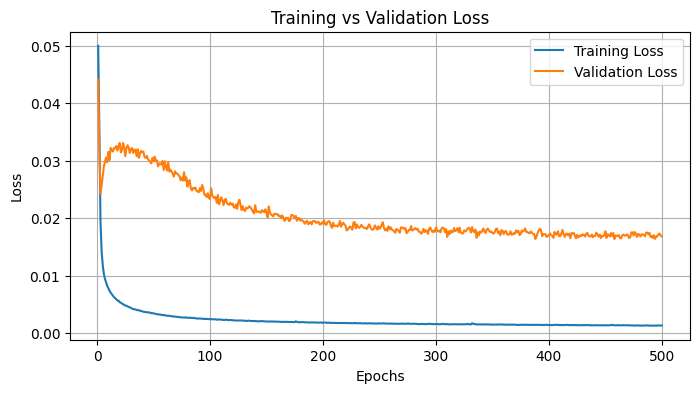

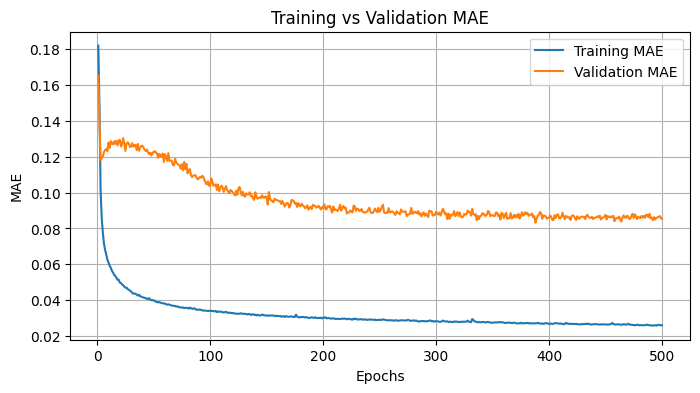

In [34]:
import matplotlib.pyplot as plt

# 繪製 Loss 和 MAE 的趨勢圖
def plot_metrics(train_loss, val_loss, train_mae, val_mae):
    epochs = range(1, len(train_loss) + 1)

    # Loss 曲線
    plt.figure(figsize=(8, 4))
    plt.plot(epochs, train_loss, label="Training Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

    # MAE 曲線
    plt.figure(figsize=(8, 4))
    plt.plot(epochs, train_mae, label="Training MAE")
    plt.plot(epochs, val_mae, label="Validation MAE")
    plt.title("Training vs Validation MAE")
    plt.xlabel("Epochs")
    plt.ylabel("MAE")
    plt.legend()
    plt.grid()
    plt.show()

# 調用函數繪製圖表
plot_metrics(train_loss_history, val_loss_history, train_mae_history, val_mae_history)

In [41]:
import numpy as np

# 隨機抽樣索引
val_sample_idx = random.randint(0, len(X_val_combined) - 1)
train_sample_idx = random.randint(0, len(X_train_combined) - 1)

# 將選取的樣本轉為張量
val_sample_X1 = torch.tensor(X_val_combined[val_sample_idx][0], dtype=torch.float32).unsqueeze(0).to(device)  # X1
val_sample_X2 = torch.tensor(X_val_combined[val_sample_idx][1], dtype=torch.float32).unsqueeze(0).to(device)  # X2
val_sample_X3 = torch.tensor(X_val_combined[val_sample_idx][2], dtype=torch.float32).unsqueeze(0).to(device)  # X3

train_sample_X1 = torch.tensor(X_train_combined[train_sample_idx][0], dtype=torch.float32).unsqueeze(0).to(device)  # X1
train_sample_X2 = torch.tensor(X_train_combined[train_sample_idx][1], dtype=torch.float32).unsqueeze(0).to(device)  # X2
train_sample_X3 = torch.tensor(X_train_combined[train_sample_idx][2], dtype=torch.float32).unsqueeze(0).to(device)  # X3

# 真值
val_sample_Y_true = torch.tensor(Y_val[val_sample_idx], dtype=torch.float32).to(device).cpu().numpy()  # Shape: (24, 4)
train_sample_Y_true = torch.tensor(Y_train[train_sample_idx], dtype=torch.float32).to(device).cpu().numpy()  # Shape: (24, 4)

# 將真值逐行反標準化
Y_val_true_original = scaler_X.inverse_transform(val_sample_Y_true)  # Shape: (24, 4)
Y_train_true_original = scaler_X.inverse_transform(train_sample_Y_true)  # Shape: (24, 4)

# 模型預測
model.eval()
val_sample_Y_pred = model(val_sample_X1, val_sample_X2, val_sample_X3).cpu().detach().numpy()  # Shape: (1, 24, 4)
train_sample_Y_pred = model(train_sample_X1, train_sample_X2, train_sample_X3).cpu().detach().numpy()  # Shape: (1, 24, 4)

# 去掉 batch 維度後反標準化
val_sample_Y_pred = val_sample_Y_pred.squeeze(0)  # Shape: (24, 4)
train_sample_Y_pred = train_sample_Y_pred.squeeze(0)  # Shape: (24, 4)

Y_val_pred_original = scaler_X.inverse_transform(val_sample_Y_pred)  # Shape: (24, 4)
Y_train_pred_original = scaler_X.inverse_transform(train_sample_Y_pred)  # Shape: (24, 4)

# 輸出結果
val_sample_result = {
    "True Value": Y_val_true_original.tolist(),
    "Predicted Value": Y_val_pred_original.tolist(),
}
train_sample_result = {
    "True Value": Y_train_true_original.tolist(),
    "Predicted Value": Y_train_pred_original.tolist(),
}

print("Validation Sample Result:", val_sample_result)
print("Training Sample Result:", train_sample_result)

Validation Sample Result: {'True Value': [[26.78299903869629, 100.00000762939453, 11542.41796875], [27.11199951171875, 100.00000762939453, 9731.166015625], [27.751998901367188, 100.00000762939453, 10806.083984375], [28.618999481201172, 100.00000762939453, 17743.33203125], [29.293001174926758, 100.00000762939453, 19230.333984375], [29.312000274658203, 100.00000762939453, 17784.916015625], [29.605998992919922, 100.00000762939453, 19146.5], [30.283000946044922, 100.00000762939453, 23814.25], [30.726001739501953, 100.00000762939453, 28096.166015625], [32.41699981689453, 100.00000762939453, 64273.23046875], [36.82600021362305, 86.36300659179688, 87886.40625], [38.89500045776367, 71.88999938964844, 89079.171875], [43.36300277709961, 52.87999725341797, 99297.1015625], [47.07999801635742, 39.84700012207031, 103244.296875], [48.14899826049805, 34.9219970703125, 107426.703125], [49.198001861572266, 29.98200035095215, 111115.6875], [50.959999084472656, 29.71099853515625, 114514.4765625], [52.9980

<ipython-input-41-95e9c88102f2>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_sample_Y_true = torch.tensor(Y_val[val_sample_idx], dtype=torch.float32).to(device).cpu().numpy()  # Shape: (24, 4)
<ipython-input-41-95e9c88102f2>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_sample_Y_true = torch.tensor(Y_train[train_sample_idx], dtype=torch.float32).to(device).cpu().numpy()  # Shape: (24, 4)


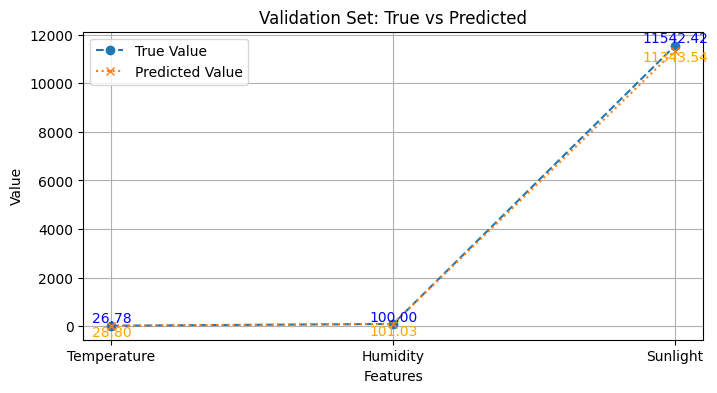

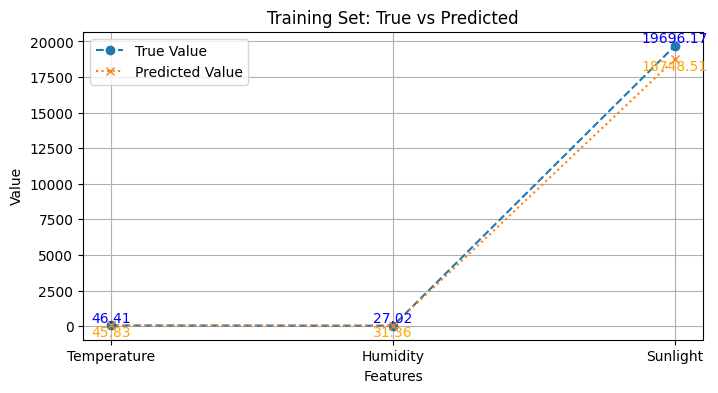

In [42]:
import matplotlib.pyplot as plt

# 繪製實際值與預測值的差異圖並標出數值
def plot_prediction_comparison_with_values(true_values, predicted_values, title, labels=None):
    plt.figure(figsize=(8, 4))

    # 繪製實際值與預測值
    plt.plot(true_values[0], label="True Value", marker="o", linestyle="--")
    plt.plot(predicted_values[0], label="Predicted Value", marker="x", linestyle=":")

    # 標出每個數值
    for i, (t, p) in enumerate(zip(true_values[0], predicted_values[0])):
        label = labels[i] if labels else f"Var {i+1}"
        plt.text(i, t, f"{t:.2f}", ha="center", va="bottom", fontsize=10, color="blue")
        plt.text(i, p, f"{p:.2f}", ha="center", va="top", fontsize=10, color="orange")

    plt.title(title)
    plt.xlabel("Features")
    plt.ylabel("Value")
    plt.legend()
    plt.grid()
    plt.xticks(range(len(true_values[0])), labels if labels else [f"Var {i+1}" for i in range(len(true_values[0]))])
    plt.show()

# 特徵名稱（可選）
feature_labels = ["Temperature", "Humidity", "Sunlight"]

# 繪製 Validation Set 結果
plot_prediction_comparison_with_values(
    Y_val_true_original, Y_val_pred_original, "Validation Set: True vs Predicted", labels=feature_labels
)

# 繪製 Training Set 結果
plot_prediction_comparison_with_values(
    Y_train_true_original, Y_train_pred_original, "Training Set: True vs Predicted", labels=feature_labels
)

## 6. Prediction on testing data (unknow)

In [43]:
initial_data_filter_v2 = initial_data_filter.copy()
initial_data_filter_v2[features] = scaler_X.transform(initial_data_filter[features])
initial_data_filter_v2

,10min_Group,Temperature(°C),Humidity(%),Sunlight(Lux),Power(mW),Date,Month,Time,Site
0,2024-01-06 07:00:00,0.037551,0.627223,0.043437,17.832,2024-01-06,2024-01,07:00:00,L1
1,2024-01-06 07:10:00,0.072041,0.627223,0.099663,84.872,2024-01-06,2024-01,07:10:00,L1
2,2024-01-06 07:20:00,0.116122,0.627223,0.112359,149.770,2024-01-06,2024-01,07:20:00,L1
3,2024-01-06 07:30:00,0.154286,0.627223,0.164468,193.418,2024-01-06,2024-01,07:30:00,L1
4,2024-01-06 07:40:00,0.174082,0.592999,0.204302,254.168,2024-01-06,2024-01,07:40:00,L1
...,...,...,...,...,...,...,...,...,...
2395,2024-10-16 08:10:00,0.580898,0.332503,0.661459,678.599,2024-10-16,2024-10,08:10:00,L7
2396,2024-10-16 08:20:00,0.598490,0.308922,0.807264,942.352,2024-10-16,2024-10,08:20:00,L7
2397,2024-10-16 08:30:00,0.628020,0.283807,0.869089,1108.636,2024-10-16,2024-10,08:30:00,L7
2398,2024-10-16 08:40:00,0.654204,0.259538,0.909225,1236.506,2024-10-16,2024-10,08:40:00,L7


In [46]:
import torch
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# 初始化存放結果的列表
predicted_all_dates_sites = []

# 模型切換為評估模式
model.eval()

# 獲取測試資料中的唯一日期和站點
unique_dates = initial_data_filter_v2['Date'].unique()
unique_sites = initial_data_filter_v2['Site'].unique()

# 時間範圍 (9:00-16:50，每10分鐘)
start_time = datetime.strptime("09:00", "%H:%M")
time_intervals = [(start_time + timedelta(minutes=10 * i)).time() for i in range(48)]

for current_date in unique_dates:
    for current_site in unique_sites:
        # **1. 準備 X1**
        # 篩選當天和當前站點的 7:00-8:50 數據作為 X1
        day_site_data = initial_data_filter_v2[
            (initial_data_filter_v2['Date'] == current_date) &
            (initial_data_filter_v2['Site'] == current_site)
        ]
        if day_site_data.empty:
            continue  # 如果該站點在當天沒有資料，跳過

        X1_input = day_site_data[['Temperature(°C)', 'Humidity(%)', 'Sunlight(Lux)']].values  # (12, 3)
        X1_tensor = torch.tensor(X1_input, dtype=torch.float32).unsqueeze(0).to(device)  # (1, 12, 3)

        # **2. 準備 X2**
        # 從 grouped_data_with_missing_v2 提取當天 9:00-16:50 的平均值
        X2_data = grouped_data_with_missing_v2[
            (pd.to_datetime(grouped_data_with_missing_v2['Date']) == pd.to_datetime(current_date))
        ]
        X2_input = X2_data[['Temperature(°C)', 'Humidity(%)', 'Sunlight(Lux)']].values  # (48, 3)
        if len(X2_input) == 0:
            print(f"Warning: No X2 data available for {current_date} - {current_site}. Skipping...")
            continue
        X2_tensor = torch.tensor(X2_input, dtype=torch.float32).unsqueeze(0).to(device)  # (1, 48, 3)

        # **3. 準備 X3**
        # 站點和日期的 One-Hot Encoding
        try:
            # 站點和日期的 One-Hot Encoding
            X3_site = current_site  # 當前站點
            X3_date = pd.to_datetime(current_date).strftime('%Y-%m-%d')  # 當前日期
            X3_data = encoder.transform([[X3_date], [X3_site]]).toarray().flatten()  # One-Hot 編碼
            X3_tensor = torch.tensor(X3_data, dtype=torch.float32).unsqueeze(0).to(device)  # (1, 558)
        except ValueError:
            # 如果日期或站點無法被 One-Hot 編碼，使用全零向量代替
            print(f"Warning: Unknown category for Date={current_date} or Site={current_site}. Using zero vector.")
            X3_tensor = torch.zeros((1, 558), dtype=torch.float32).to(device)

        with torch.no_grad():
            predicted = model(X1_tensor, X2_tensor, X3_tensor)  # 預測 (1, 48, 3)

        # **5. 整理結果**
        predicted_results = predicted.cpu().detach().numpy()[0]  # 提取 numpy 結果 (48, 3)
        predicted_df = pd.DataFrame(
            predicted_results,
            columns=['Temperature(°C)', 'Humidity(%)', 'Sunlight(Lux)']
        )
        predicted_df['Date'] = current_date
        predicted_df['Month'] = pd.to_datetime(current_date).to_period('M')
        predicted_df['Time'] = time_intervals
        predicted_df['Site'] = current_site
        predicted_all_dates_sites.append(predicted_df)

# **6. 合併所有天數和站點的結果**
final_predicted_df = pd.concat(predicted_all_dates_sites, ignore_index=True)

# **7. 檢視預測結果**
print(final_predicted_df.head())

   Temperature(°C)  Humidity(%)  Sunlight(Lux)        Date    Month      Time  \
0         0.372186     0.262227       0.664688  2024-01-06  2024-01  09:00:00   
1         0.395714     0.233298       0.640397  2024-01-06  2024-01  09:10:00   
2         0.408067     0.218992       0.719922  2024-01-06  2024-01  09:20:00   
3         0.453824     0.199011       0.806748  2024-01-06  2024-01  09:30:00   
4         0.495555     0.176863       0.813010  2024-01-06  2024-01  09:40:00   

  Site  
0   L1  
1   L1  
2   L1  
3   L1  
4   L1  


In [49]:
final_predicted_df

,Temperature(°C),Humidity(%),Sunlight(Lux),Date,Month,Time,Site
0,0.372186,0.262227,0.664688,2024-01-06,2024-01,09:00:00,L1
1,0.395714,0.233298,0.640397,2024-01-06,2024-01,09:10:00,L1
2,0.408067,0.218992,0.719922,2024-01-06,2024-01,09:20:00,L1
3,0.453824,0.199011,0.806748,2024-01-06,2024-01,09:30:00,L1
4,0.495555,0.176863,0.813010,2024-01-06,2024-01,09:40:00,L1
...,...,...,...,...,...,...,...
9595,0.366599,0.524932,0.091680,2024-09-18,2024-09,16:10:00,L7
9596,0.370779,0.518856,0.086387,2024-09-18,2024-09,16:20:00,L7
9597,0.362764,0.525917,0.056806,2024-09-18,2024-09,16:30:00,L7
9598,0.352770,0.536585,0.055196,2024-09-18,2024-09,16:40:00,L7


In [47]:
all_sites_combined_data_v2[['Temperature(°C)','Humidity(%)','Sunlight(Lux)','Date','Month','Time','Site']].dtypes

,0
Temperature(°C),float64
Humidity(%),float64
Sunlight(Lux),float64
Date,object
Month,period[M]
Time,object
Site,object


In [48]:
final_predicted_df.dtypes

,0
Temperature(°C),float32
Humidity(%),float32
Sunlight(Lux),float32
Date,object
Month,period[M]
Time,object
Site,object


## 7. Prediction on training data and train a ML model

In [50]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from xgboost import XGBRegressor, cv, DMatrix
import xgboost as xgb

# 分離解釋變數與目標變數
X = all_sites_combined_data_v2.drop(columns=['Power(mW)','10min_Group'])
y = all_sites_combined_data_v2['Power(mW)']

X['Date'] = pd.to_datetime(X['Date']).dt.day

# 切分訓練集與測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=30)

# 將時間相關欄位轉換為 category 型別
categorical_columns = ['Site', 'Month', 'Date','Time']
for col in categorical_columns:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype('category')
    if col in X_test.columns:
        X_test[col] = X_test[col].astype('category')


# 將資料轉換為 DMatrix 格式
dtrain = DMatrix(X_train, label=y_train,enable_categorical=True)

# 定義參數範圍
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 6,
    'eta': 0.1
}

# 使用 XGBoost 的交叉驗證功能來選擇最佳 n_estimators
cv_results = cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,  # 最大迭代次數
    early_stopping_rounds=50,  # 提前停止條件
    nfold=5,  # 5 折交叉驗證
    seed=42,
    as_pandas=True,
    verbose_eval=True
)

# 選擇最佳的 n_estimators
best_n_estimators = len(cv_results)
print(f"Best n_estimators: {best_n_estimators}")

# 用最佳參數訓練模型
xgb_model = XGBRegressor(
    n_estimators=best_n_estimators,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    enable_categorical=True
)

xgb_model.fit(X_train, y_train)

# 預測
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)



# 檢查並轉換為字符串
for col in categorical_columns:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype(str)
    if col in X_test.columns:
        X_test[col] = X_test[col].astype(str)

catboost_model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    cat_features=[X_train.columns.get_loc(col) for col in categorical_columns],
    verbose=0,
    random_seed=42
)
catboost_model.fit(X_train, y_train)

catboost_pred = catboost_model.predict(X_test)

# 4. 加權平均進行 Ensemble
ensemble_pred = 0.6 * y_pred_test + 0.4 * catboost_pred  # 權重可以根據驗證集調整

# 5. 評估
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    sae = np.sum(np.abs(y_true - y_pred))
    print(f"{model_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, SAE: {sae:.2f}")

# 個別模型評估
evaluate_model(y_test, y_pred_test, "XGBoost")
evaluate_model(y_test, catboost_pred, "CatBoost")

# Ensemble 模型評估
evaluate_model(y_test, ensemble_pred, "Ensemble Model")

[0]	train-rmse:469.70402+0.63417	test-rmse:469.82443+2.55537
[1]	train-rmse:426.15000+0.59801	test-rmse:426.37835+2.30936
[2]	train-rmse:387.12909+0.46905	test-rmse:387.49850+2.09636
[3]	train-rmse:352.16965+0.44931	test-rmse:352.68724+1.82681
[4]	train-rmse:320.93343+0.41782	test-rmse:321.61358+1.59954
[5]	train-rmse:293.07435+0.39931	test-rmse:293.93615+1.43020
[6]	train-rmse:268.20399+0.41155	test-rmse:269.25570+1.26798
[7]	train-rmse:245.96833+0.39571	test-rmse:247.20680+1.10699
[8]	train-rmse:226.21476+0.38087	test-rmse:227.66158+0.96495
[9]	train-rmse:208.75230+0.40274	test-rmse:210.41140+0.85012
[10]	train-rmse:193.22982+0.45347	test-rmse:195.16869+0.74597
[11]	train-rmse:179.43133+0.46154	test-rmse:181.59673+0.62509
[12]	train-rmse:167.27565+0.40995	test-rmse:169.72235+0.55804
[13]	train-rmse:156.56860+0.37951	test-rmse:159.28006+0.55068
[14]	train-rmse:147.11549+0.45374	test-rmse:150.10488+0.51726
[15]	train-rmse:138.78680+0.44472	test-rmse:142.12848+0.56431
[16]	train-rmse:13

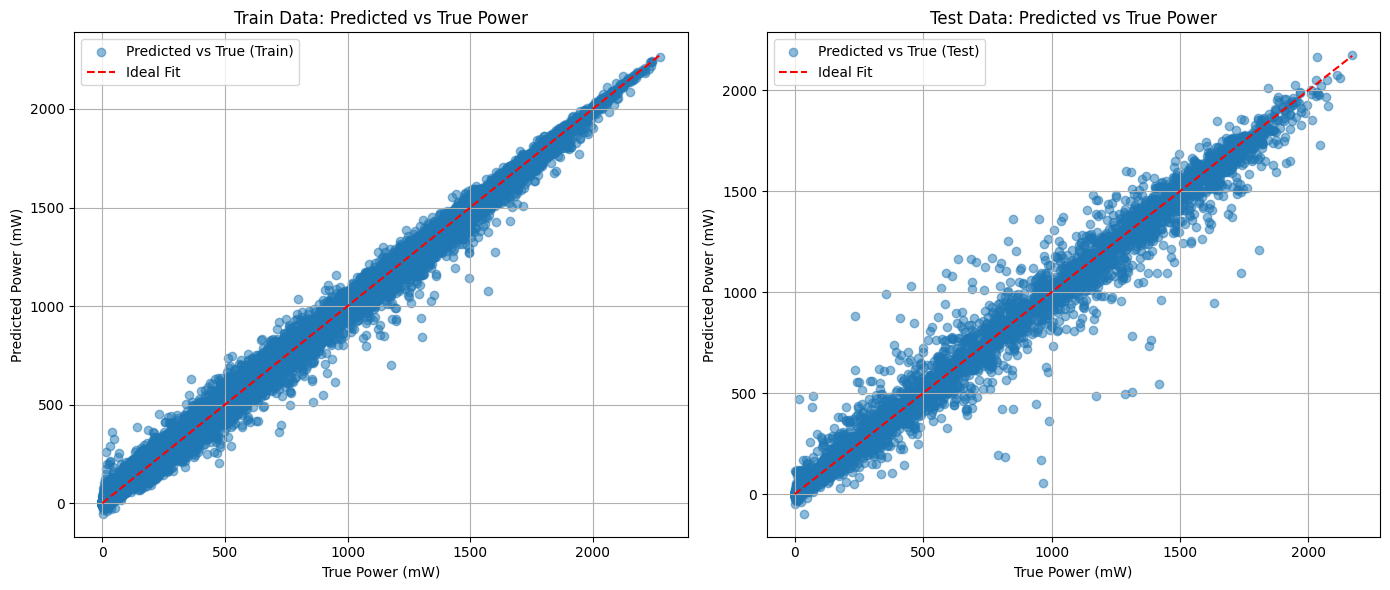

In [51]:
# Assuming y_train, y_pred_train, y_test, and y_pred_test are available

# Create scatter plot for train data
plt.figure(figsize=(14, 6))

# Train data scatter plot
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_pred_train, alpha=0.5, label="Predicted vs True (Train)")
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'r--', label="Ideal Fit")
plt.xlabel("True Power (mW)")
plt.ylabel("Predicted Power (mW)")
plt.title("Train Data: Predicted vs True Power")
plt.legend()
plt.grid(True)

# Test data scatter plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_test, alpha=0.5, label="Predicted vs True (Test)")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label="Ideal Fit")
plt.xlabel("True Power (mW)")
plt.ylabel("Predicted Power (mW)")
plt.title("Test Data: Predicted vs True Power")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

<Figure size 1000x800 with 0 Axes>

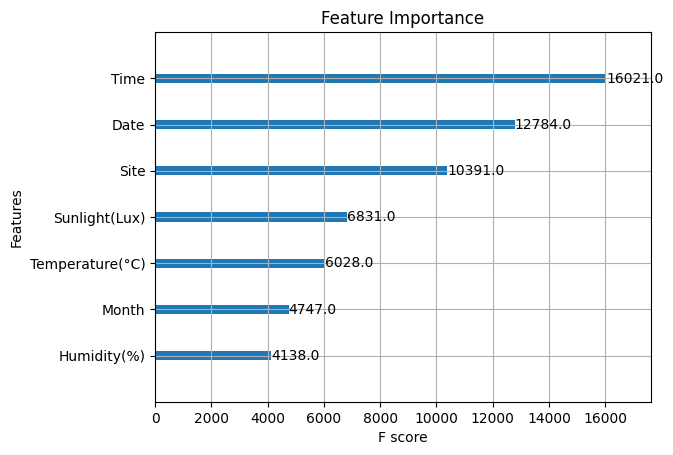

In [52]:
import xgboost as xgb

# Plot feature importance using XGBoost's built-in plot function
plt.figure(figsize=(10, 8))
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10, title="Feature Importance")
plt.show()

## 7-1 Train ML model

In [53]:
merged_final_predicted_df_ML = final_predicted_df.copy()
merged_final_predicted_df_ML['Date2'] = merged_final_predicted_df_ML['Date']
merged_final_predicted_df_ML['Date'] = pd.to_datetime(merged_final_predicted_df_ML['Date']).dt.day

# 確保 Date, Time, Month 欄位被轉換為 category 型別
categorical_columns = ['Site', 'Month', 'Date','Time']
for col in categorical_columns:
    if col in merged_final_predicted_df_ML.columns:
        merged_final_predicted_df_ML[col] = merged_final_predicted_df_ML[col].astype('category')

# 準備模型輸入特徵
X_test_final = merged_final_predicted_df_ML

# 使用 XGBoost 模型進行預測
X_test_final = X_test_final[X_train.columns]
Power_Pred_xg = xgb_model.predict(X_test_final)

# 確保 categorical_columns 是正確的
categorical_columns = ['Site', 'Month', 'Date','Time']

# 檢查並轉換為字符串
for col in categorical_columns:
    if col in merged_final_predicted_df_ML.columns:
        merged_final_predicted_df_ML[col] = merged_final_predicted_df_ML[col].astype(str)

X_test_final = merged_final_predicted_df_ML
X_test_final = X_test_final[X_train.columns]
Power_Pred_cb = catboost_model.predict(X_test_final)

merged_final_predicted_df_ML['Final_Power_Pred'] = 0.6*Power_Pred_xg + 0.4*Power_Pred_cb

# 針對預測結果小於 0 的部分改成 0
merged_final_predicted_df_ML['Final_Power_Pred'] = merged_final_predicted_df_ML['Final_Power_Pred'].apply(
    lambda x: max(x, 0)
)

# 查看結果
merged_final_predicted_df_ML.head()

,Temperature(°C),Humidity(%),Sunlight(Lux),Date,Month,Time,Site,Date2,Final_Power_Pred
0,0.372186,0.262227,0.664688,6,2024-01,09:00:00,L1,2024-01-06,1283.315386
1,0.395714,0.233298,0.640397,6,2024-01,09:10:00,L1,2024-01-06,1255.219272
2,0.408067,0.218992,0.719922,6,2024-01,09:20:00,L1,2024-01-06,1388.620623
3,0.453824,0.199011,0.806748,6,2024-01,09:30:00,L1,2024-01-06,1566.848547
4,0.495555,0.176863,0.813010,6,2024-01,09:40:00,L1,2024-01-06,1583.081437


In [54]:
merged_final_predicted_df_ML['site_code'] = merged_final_predicted_df_ML['Site'].str.extract(r'(\d+)').astype(int).map("{:02d}".format)
merged_final_predicted_df_ML

,Temperature(°C),Humidity(%),Sunlight(Lux),Date,Month,Time,Site,Date2,Final_Power_Pred,site_code
0,0.372186,0.262227,0.664688,6,2024-01,09:00:00,L1,2024-01-06,1283.315386,01
1,0.395714,0.233298,0.640397,6,2024-01,09:10:00,L1,2024-01-06,1255.219272,01
2,0.408067,0.218992,0.719922,6,2024-01,09:20:00,L1,2024-01-06,1388.620623,01
3,0.453824,0.199011,0.806748,6,2024-01,09:30:00,L1,2024-01-06,1566.848547,01
4,0.495555,0.176863,0.813010,6,2024-01,09:40:00,L1,2024-01-06,1583.081437,01
...,...,...,...,...,...,...,...,...,...,...
9595,0.366599,0.524932,0.091680,18,2024-09,16:10:00,L7,2024-09-18,11.449083,07
9596,0.370779,0.518856,0.086387,18,2024-09,16:20:00,L7,2024-09-18,13.033185,07
9597,0.362764,0.525917,0.056806,18,2024-09,16:30:00,L7,2024-09-18,0.000000,07
9598,0.352770,0.536585,0.055196,18,2024-09,16:40:00,L7,2024-09-18,0.000000,07


In [55]:
merged_final_predicted_df_ML['label'] = (
    merged_final_predicted_df_ML['Date2'].astype(str).str.replace('-', '') +  # 強制轉為字符串並去掉'-'
    merged_final_predicted_df_ML['Time'].astype(str).str.replace(':', '').str[:4] +  # 強制轉為字符串並取前4位 (時分)
    merged_final_predicted_df_ML['site_code']  # site_code 部分
)
merged_final_predicted_df_ML.sort_values(by=['Date2','Time'])

,Temperature(°C),Humidity(%),Sunlight(Lux),Date,Month,Time,Site,Date2,Final_Power_Pred,site_code,label
0,0.372186,0.262227,0.664688,6,2024-01,09:00:00,L1,2024-01-06,1283.315386,01,20240106090001
1,0.395714,0.233298,0.640397,6,2024-01,09:10:00,L1,2024-01-06,1255.219272,01,20240106091001
2,0.408067,0.218992,0.719922,6,2024-01,09:20:00,L1,2024-01-06,1388.620623,01,20240106092001
3,0.453824,0.199011,0.806748,6,2024-01,09:30:00,L1,2024-01-06,1566.848547,01,20240106093001
4,0.495555,0.176863,0.813010,6,2024-01,09:40:00,L1,2024-01-06,1583.081437,01,20240106094001
...,...,...,...,...,...,...,...,...,...,...,...
5995,0.371395,0.600429,0.037881,28,2024-10,16:10:00,L8,2024-10-28,0.000000,08,20241028161008
5996,0.364325,0.608154,0.032883,28,2024-10,16:20:00,L8,2024-10-28,0.000000,08,20241028162008
5997,0.362405,0.612492,0.032390,28,2024-10,16:30:00,L8,2024-10-28,0.000000,08,20241028163008
5998,0.356592,0.624353,0.028349,28,2024-10,16:40:00,L8,2024-10-28,0.000000,08,20241028164008


In [56]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/Data science competition/T-brain 2024 Sun light Power predition/Testing data')
df_testing = pd.read_csv('upload.csv')
df_testing.head()

,序號,答案
0,20240117090001,NaN
1,20240117091001,NaN
2,20240117092001,NaN
3,20240117093001,NaN
4,20240117094001,NaN


In [57]:
# Rounding 'Final_Power_Pred' to 2 decimal places
merged_final_predicted_df_ML['Final_Power_Pred'] = merged_final_predicted_df_ML['Final_Power_Pred'].round(2)
merged_final_predicted_df_ML['label'] = merged_final_predicted_df_ML['label'].astype(int)
# Merging the prediction data into the testing dataframe
df_testing = df_testing.merge(
    merged_final_predicted_df_ML[['label', 'Final_Power_Pred']],
    how='left',
    left_on='序號',
    right_on='label'
)

# Updating the '答案' column in the testing dataframe with the predictions
df_testing['答案'] = df_testing['Final_Power_Pred']

# Dropping unnecessary columns like 'label' if not needed anymore
df_testing.drop(columns=['label','Final_Power_Pred'], inplace=True)

# Displaying the updated dataframe
df_testing.head()

,序號,答案
0,20240117090001,99.57
1,20240117091001,77.61
2,20240117092001,141.86
3,20240117093001,73.58
4,20240117094001,54.18


In [60]:
df_testing['答案'].isna().sum()

0

In [58]:
file_path = url_output + "upload_4" + ".csv"
df_testing.to_csv(file_path, index=False)
file_path

'/content/drive/MyDrive/Colab Notebooks/Data science competition/T-brain 2024 Sun light Power predition/Testing data/upload_4.csv'